# West Nile Virus Presence Prediction
### Methods: 
* Using Past Weathers
* Using Oversampling to balance classes
* Using Feature Selection on Feature Importance


In [126]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from imblearn.over_sampling import RandomOverSampler




In [28]:
df_weather = pd.read_csv('weather.csv')
df_weather = df_weather.drop(['Depart', 'Sunrise', 'Sunset', 'Depth', 'CodeSum', 'Water1' ,'SnowFall'] , axis=1)
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,51,56,0,2,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,51,57,0,3,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,42,47,14,0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,42,47,13,0,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,40,48,9,0,0.00,29.39,30.12,11.7,7,11.9


In [30]:
df_weather = df_weather.replace('M', np.nan)
df_weather = df_weather.replace('  T', 0.00)

indices = ['Station','Date'] 
otherIndices = df_weather.columns.difference(indices)

df_weather[otherIndices] = df_weather[otherIndices].astype(float)

df_weather = df_weather.fillna(df_weather.mean())
#df_weather.isnull().describe()
#df_weather['joinID'] = df_weather['Date'].astype(str)+df_weather['Station'].astype(str)
#df_weather.head(2)

In [24]:
# find the nearest station
def mapStation(loc):
    station1 = np.array([41.995,-87.933])
    station2 = np.array([41.786,-87.752])
    testStation = np.array([loc[0],loc[1]])
    distance1 = np.linalg.norm(station1-testStation)
    distance2 = np.linalg.norm(station2-testStation)
    #print(distance1,distance2)
    if distance1 < distance2 : return 1
    return 2

In [31]:
df_train = pd.read_csv('train.csv')

lat_lon = df_train[['Latitude','Longitude']].copy()
df_train['Station'] = lat_lon.apply(mapStation, axis=1)

df_train = df_train[['Date','Station','Species','WnvPresent']]
#df_train['joinID'] = df_train['Date'].astype(str)+df_train['Station'].astype(str)

df_train.head()

,Date,Station,Species,WnvPresent
0,2007-05-29,1,CULEX PIPIENS/RESTUANS,0
1,2007-05-29,1,CULEX RESTUANS,0
2,2007-05-29,1,CULEX RESTUANS,0
3,2007-05-29,1,CULEX PIPIENS/RESTUANS,0
4,2007-05-29,1,CULEX RESTUANS,0


In [51]:
# weather dictionary key {data and station}
weather = {}
for info in df_weather.values:
    #print(info[1])
    date = info[1]
    if date not in weather:
        weather[date] = {1: None, 2: None}
    weather[date][info[0]] = info[2:]

In [143]:
import datetime
def constructWeather(df, num_past_days=2):
    date_station = df.values
    #d = date_station[:,:2]
    #print(df.values)
    w = []
    for d in date_station:
        
        station = d[1]
        row = weather[d[0]][station].tolist()
        dt = datetime.datetime.strptime(str(d[0]), "%Y-%m-%d")
        
        for i in range(num_past_days):
            past_date = dt - datetime.timedelta(days=i+1)
            past_date = past_date.strftime("%Y-%m-%d")
            #print(past_date, station)
            #print(weather[past_date][station].tolist())
            row += weather[past_date][station].tolist()
        w.append(row)
    return pd.concat([df, pd.DataFrame(w)], axis=1)

In [301]:
def train(X , y, classifier, valid_split=0.3, normalize=False):
    trainX, validX, trainY, validY = train_test_split(X, y, test_size=valid_split, random_state=42)
    if normalize:
        z_score = StandardScaler()
        trainX = z_score.fit_transform(trainX)
        validX = z_score.transform(validX)
    
    classifier.fit(X,y)
    print('Training score :\n', classifier.score(trainX, trainY))
    print(metrics.classification_report(trainY, classifier.predict(trainX)))
    print(metrics.confusion_matrix(trainY, classifier.predict(trainX)))
    
    print('Validaing score :\n', classifier.score(validX, validY))
    print(metrics.classification_report(validY, classifier.predict(validX)))
    print(metrics.confusion_matrix(validY, classifier.predict(validX)))
    return classifier

In [302]:
def addPast(df, n_days=2):
    #n_days  past day weather consideration
    df_main = constructWeather(df, num_past_days=n_days)

    label = df_main['WnvPresent'].values
    df_main = df_main[df_main.columns.difference(['Date','Station', 'WnvPresent'])]
    df_main = pd.get_dummies(df_main)
    return label, df_main


In [303]:
def model(df, n_days, classifier, split=0.2, normalize=False):
    y, dfX = addPast(df, n_days=n_days)
    clf = train(dfX.values, y, classifier, valid_split=split, normalize=normalize)
    return clf

In [304]:
# classifier 
lr = LogisticRegression()
#train(df_main.values, label, lr, valid_split=0.1)
trained_model = model(df_train, 20, lr, split=0.2, normalize=True)

Training score :
 0.46596858638743455
             precision    recall  f1-score   support

          0       0.98      0.44      0.61      7963
          1       0.08      0.88      0.15       441

avg / total       0.94      0.47      0.59      8404

[[3530 4433]
 [  55  386]]
Validaing score :
 0.47002854424357754
             precision    recall  f1-score   support

          0       0.98      0.45      0.62      1992
          1       0.08      0.82      0.14       110

avg / total       0.93      0.47      0.59      2102

[[ 898 1094]
 [  20   90]]


Training score :
 0.6406037530595594
             precision    recall  f1-score   support

          0       0.97      0.64      0.77      6969
          1       0.09      0.64      0.16       385

avg / total       0.92      0.64      0.74      7354

[[4464 2505]
 [ 138  247]]
Validaing score :
 0.6357868020304569
             precision    recall  f1-score   support

          0       0.97      0.63      0.77      2986
          1       0.10      0.70      0.17       166

avg / total       0.93      0.64      0.74      3152

[[1887 1099]
 [  49  117]]


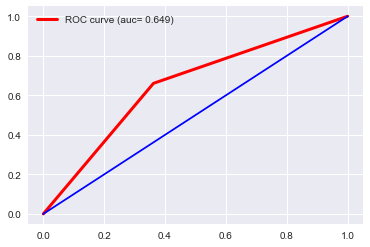

In [306]:

mnb = MultinomialNB()
trained_model = model(df_train, 5, mnb, split=0.3) #5 past day weather
#train(df_main.values, label, mnb, valid_split=0.1)

y, dfX = addPast(df_train, n_days=5)
fpr, tpr, threshold = metrics.roc_curve(y, trained_model.predict(dfX))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='r', lw=3, label='ROC curve (auc= %0.3f)'%roc_auc)
plt.plot([0,1],[0,1], 'b-')
plt.legend(loc='best')
plt.show()

### OverSampling to balance the classes

In [207]:
y, X = addPast(df_train,n_days=15)
os = RandomOverSampler()
X_resampled, y_resampled = os.fit_sample(X.values, y)
model= train(X_resampled , y_resampled, lr, valid_split=0.1, normalize=False)

Training score :
 0.7881578213069925
             precision    recall  f1-score   support

          0       0.82      0.74      0.78      8944
          1       0.76      0.84      0.80      8975

avg / total       0.79      0.79      0.79     17919

[[6592 2352]
 [1444 7531]]
Validaing score :
 0.7850326469111
             precision    recall  f1-score   support

          0       0.83      0.73      0.77      1011
          1       0.75      0.84      0.79       980

avg / total       0.79      0.79      0.78      1991

[[737 274]
 [154 826]]


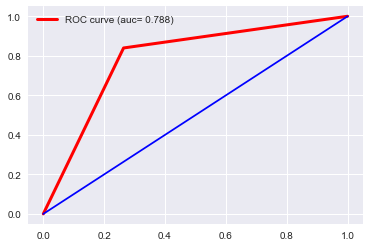

In [209]:
fpr, tpr, threshold = metrics.roc_curve(y_resampled, model.predict(X_resampled))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='r', lw=3, label='ROC curve (auc= %0.3f)'%roc_auc)
plt.plot([0,1],[0,1], 'b-')
plt.legend(loc='best')
plt.show()

Training score :
 0.6629834254143646
             precision    recall  f1-score   support

          0       0.73      0.52      0.61      8944
          1       0.63      0.81      0.71      8975

avg / total       0.68      0.66      0.66     17919

[[4645 4299]
 [1740 7235]]
Validaing score :
 0.6619789050728278
             precision    recall  f1-score   support

          0       0.73      0.53      0.61      1011
          1       0.62      0.80      0.70       980

avg / total       0.68      0.66      0.66      1991

[[531 480]
 [193 787]]


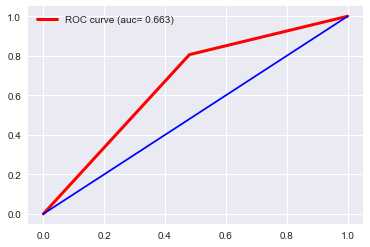

In [218]:
y, X = addPast(df_train,n_days=7)
os = RandomOverSampler()
X_resampled, y_resampled = os.fit_sample(X.values, y)
model= train(X_resampled , y_resampled, mnb, valid_split=0.1, normalize=False)
fpr, tpr, threshold = metrics.roc_curve(y_resampled, model.predict(X_resampled))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='r', lw=3, label='ROC curve (auc= %0.3f)'%roc_auc)
plt.plot([0,1],[0,1], 'b-')
plt.legend(loc='best')
plt.show()

Training score :
 0.8002120654054355
             precision    recall  f1-score   support

          0       0.84      0.74      0.79      8944
          1       0.77      0.86      0.81      8975

avg / total       0.81      0.80      0.80     17919

[[6590 2354]
 [1226 7749]]
Validaing score :
 0.7885484681064792
             precision    recall  f1-score   support

          0       0.83      0.73      0.78      1011
          1       0.75      0.85      0.80       980

avg / total       0.79      0.79      0.79      1991

[[739 272]
 [149 831]]


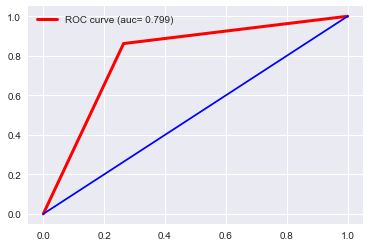

In [224]:
gbc = GradientBoostingClassifier()

y, X = addPast(df_train,n_days=20)
os = RandomOverSampler()
X_resampled, y_resampled = os.fit_sample(X.values, y)
model= train(X_resampled , y_resampled, gbc, valid_split=0.1, normalize=False)
fpr, tpr, threshold = metrics.roc_curve(y_resampled, model.predict(X_resampled))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='r', lw=3, label='ROC curve (auc= %0.3f)'%roc_auc)
plt.plot([0,1],[0,1], 'b-')
plt.legend(loc='best')
plt.show()

Training score :
 0.7876555611362241
             precision    recall  f1-score   support

          0       0.82      0.74      0.78      8944
          1       0.76      0.84      0.80      8975

avg / total       0.79      0.79      0.79     17919

[[6587 2357]
 [1448 7527]]
Validaing score :
 0.7890507282772476
             precision    recall  f1-score   support

          0       0.83      0.73      0.78      1011
          1       0.75      0.85      0.80       980

avg / total       0.79      0.79      0.79      1991

[[738 273]
 [147 833]]


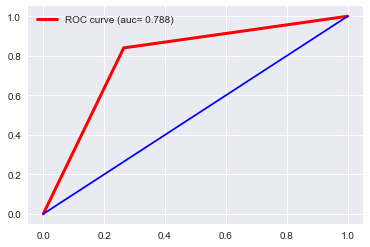

In [239]:
from sklearn.ensemble import AdaBoostClassifier
adc = AdaBoostClassifier(n_estimators=500, learning_rate=1.0)
from imblearn.over_sampling import RandomOverSampler
y, X = addPast(df_train,n_days=6)
os = RandomOverSampler()
X_resampled, y_resampled = os.fit_sample(X.values, y)
model= train(X_resampled , y_resampled, adc, valid_split=0.1, normalize=False)
fpr, tpr, threshold = metrics.roc_curve(y_resampled, model.predict(X_resampled))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='r', lw=3, label='ROC curve (auc= %0.3f)'%roc_auc)
plt.plot([0,1],[0,1], 'b-')
plt.legend(loc='best')
plt.show()

C:\Users\10257559\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\10257559\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\10257559\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\10257559\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocess

Training score :
 0.7975333444946705
             precision    recall  f1-score   support

          0       0.84      0.73      0.78      8944
          1       0.76      0.86      0.81      8975

avg / total       0.80      0.80      0.80     17919

[[6534 2410]
 [1218 7757]]
Validaing score :
 0.7975891511803114


C:\Users\10257559\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\10257559\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\10257559\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

          0       0.85      0.73      0.78      1011
          1       0.76      0.87      0.81       980

avg / total       0.80      0.80      0.80      1991

[[735 276]
 [127 853]]


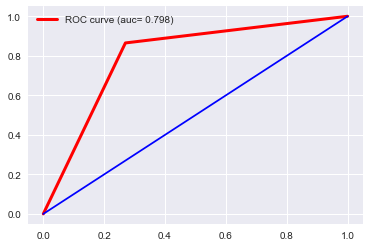

In [241]:
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
from imblearn.over_sampling import RandomOverSampler
y, X = addPast(df_train,n_days=6)
os = RandomOverSampler()
X_resampled, y_resampled = os.fit_sample(X.values, y)
model= train(X_resampled , y_resampled, clf, valid_split=0.1, normalize=False)
fpr, tpr, threshold = metrics.roc_curve(y_resampled, model.predict(X_resampled))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='r', lw=3, label='ROC curve (auc= %0.3f)'%roc_auc)
plt.plot([0,1],[0,1], 'b-')
plt.legend(loc='best')
plt.show()

In [297]:
y, X = addPast(df_train,n_days=15)
os = RandomOverSampler()
X_resampled, y_resampled = os.fit_sample(X.values, y)
lr = LogisticRegression(penalty='l1', C=0.1)
model= train(X_resampled , y_resampled, lr, valid_split=0.1, normalize=False)

Training score :
 0.7845861934259725
             precision    recall  f1-score   support

          0       0.81      0.74      0.77      8944
          1       0.76      0.83      0.79      8975

avg / total       0.79      0.78      0.78     17919

[[6583 2361]
 [1499 7476]]
Validaing score :
 0.7855349070818685
             precision    recall  f1-score   support

          0       0.83      0.72      0.77      1011
          1       0.75      0.85      0.80       980

avg / total       0.79      0.79      0.78      1991

[[732 279]
 [148 832]]


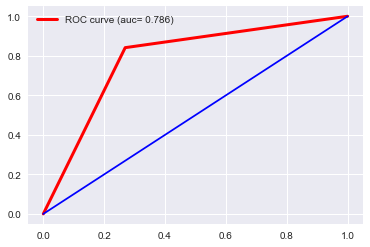

In [243]:
fpr, tpr, threshold = metrics.roc_curve(y_resampled, model.predict(X_resampled))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='r', lw=3, label='ROC curve (auc= %0.3f)'%roc_auc)
plt.plot([0,1],[0,1], 'b-')
plt.legend(loc='best')
plt.show()

## Using Important Features : Feature Selection 

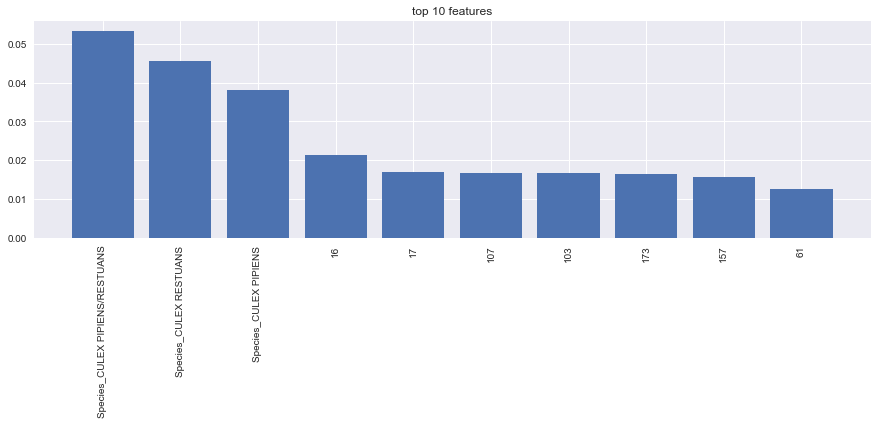

In [286]:
y, X = addPast(df_train,n_days=15)
os = RandomOverSampler()
X_resampled, y_resampled = os.fit_sample(X.values, y)
rfc = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
rfc.fit(X_resampled, y_resampled)
fi = rfc.feature_importances_
features = pd.DataFrame(X.columns)
features[1] = fi
features.columns = ['feature', 'importance']
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
fig= plt.figure(figsize=(15,4))
#plt.bar(range(features.shape[0]), fi)
f = features.head(10)
plt.bar(range(f.shape[0]), f['importance'])
plt.xticks(range(f.shape[0]),f['feature'], rotation=90)
plt.title('top 10 features')
plt.show()


(19910, 50)
Training score :
 0.8121546961325967
             precision    recall  f1-score   support

          0       0.86      0.74      0.80      8944
          1       0.77      0.88      0.82      8975

avg / total       0.82      0.81      0.81     17919

[[6634 2310]
 [1056 7919]]
Validaing score :
 0.7935710698141637
             precision    recall  f1-score   support

          0       0.85      0.72      0.78      1011
          1       0.75      0.87      0.81       980

avg / total       0.80      0.79      0.79      1991

[[731 280]
 [131 849]]


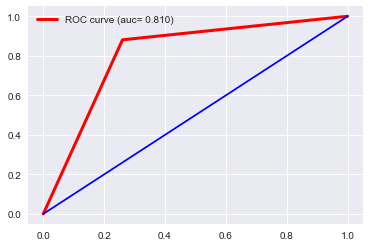

In [293]:
#using to 50 features
X_resampled, y_resampled = os.fit_sample(X[features['feature'][:50].tolist()].values, y)
print(X_resampled.shape)
model= train(X_resampled , y_resampled, rfc, valid_split=0.1, normalize=False)
fpr, tpr, threshold = metrics.roc_curve(y_resampled, model.predict(X_resampled))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='r', lw=3, label='ROC curve (auc= %0.3f)'%roc_auc)
plt.plot([0,1],[0,1], 'b-')
plt.legend(loc='best')
plt.show()

(19910, 70)
Training score :
 0.8089737150510631
             precision    recall  f1-score   support

          0       0.85      0.75      0.80      8944
          1       0.77      0.87      0.82      8975

avg / total       0.81      0.81      0.81     17919

[[6669 2275]
 [1148 7827]]
Validaing score :
 0.7915620291310899
             precision    recall  f1-score   support

          0       0.83      0.73      0.78      1011
          1       0.76      0.85      0.80       980

avg / total       0.80      0.79      0.79      1991

[[743 268]
 [147 833]]


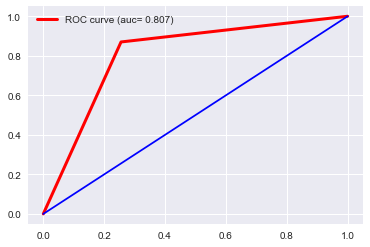

In [294]:
#using to 70 features
X_resampled, y_resampled = os.fit_sample(X[features['feature'][:70].tolist()].values, y)
print(X_resampled.shape)
model= train(X_resampled , y_resampled, rfc, valid_split=0.1, normalize=False)
fpr, tpr, threshold = metrics.roc_curve(y_resampled, model.predict(X_resampled))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='r', lw=3, label='ROC curve (auc= %0.3f)'%roc_auc)
plt.plot([0,1],[0,1], 'b-')
plt.legend(loc='best')
plt.show()

(19910, 60)
Training score :
 0.8105921089346504
             precision    recall  f1-score   support

          0       0.85      0.75      0.80      8944
          1       0.78      0.87      0.82      8975

avg / total       0.81      0.81      0.81     17919

[[6719 2225]
 [1169 7806]]
Validaing score :
 0.8061275740833752
             precision    recall  f1-score   support

          0       0.86      0.74      0.79      1011
          1       0.76      0.88      0.82       980

avg / total       0.81      0.81      0.81      1991

[[747 264]
 [122 858]]


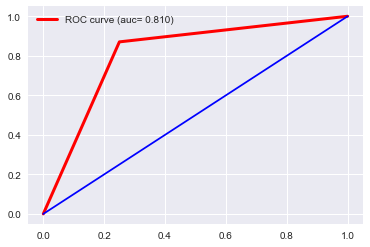

In [295]:
#using to 60 features
X_resampled, y_resampled = os.fit_sample(X[features['feature'][:60].tolist()].values, y)
print(X_resampled.shape)
model= train(X_resampled , y_resampled, rfc, valid_split=0.1, normalize=False)
fpr, tpr, threshold = metrics.roc_curve(y_resampled, model.predict(X_resampled))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='r', lw=3, label='ROC curve (auc= %0.3f)'%roc_auc)
plt.plot([0,1],[0,1], 'b-')
plt.legend(loc='best')
plt.show()

(19910, 30)
Training score :
 0.8094759752218316
             precision    recall  f1-score   support

          0       0.86      0.74      0.79      8944
          1       0.77      0.88      0.82      8975

avg / total       0.82      0.81      0.81     17919

[[6575 2369]
 [1045 7930]]
Validaing score :
 0.8051230537418382
             precision    recall  f1-score   support

          0       0.87      0.72      0.79      1011
          1       0.76      0.89      0.82       980

avg / total       0.82      0.81      0.80      1991

[[729 282]
 [106 874]]


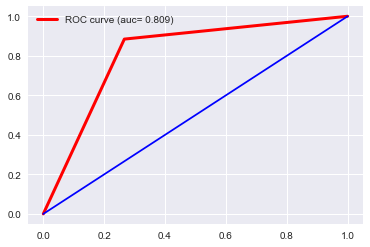

In [296]:
#using to 30 features
X_resampled, y_resampled = os.fit_sample(X[features['feature'][:30].tolist()].values, y)
print(X_resampled.shape)
model= train(X_resampled , y_resampled, rfc, valid_split=0.1, normalize=False)
fpr, tpr, threshold = metrics.roc_curve(y_resampled, model.predict(X_resampled))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='r', lw=3, label='ROC curve (auc= %0.3f)'%roc_auc)
plt.plot([0,1],[0,1], 'b-')
plt.legend(loc='best')
plt.show()

(19910, 10)
Training score :
 0.8147776103577209
             precision    recall  f1-score   support

          0       0.87      0.74      0.80      8944
          1       0.78      0.89      0.83      8975

avg / total       0.82      0.81      0.81     17919

[[6635 2309]
 [1010 7965]]
Validaing score :
 0.8076343545956806
             precision    recall  f1-score   support

          0       0.87      0.73      0.79      1011
          1       0.76      0.89      0.82       980

avg / total       0.82      0.81      0.81      1991

[[738 273]
 [110 870]]


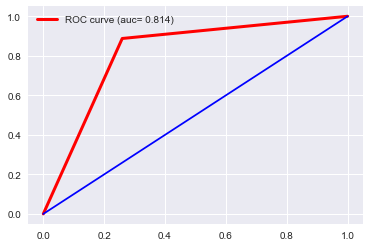

In [307]:
#using to 10 features
X_resampled, y_resampled = os.fit_sample(X[features['feature'][:10].tolist()].values, y)
print(X_resampled.shape)
model= train(X_resampled , y_resampled, rfc, valid_split=0.1, normalize=False)
fpr, tpr, threshold = metrics.roc_curve(y_resampled, model.predict(X_resampled))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='r', lw=3, label='ROC curve (auc= %0.3f)'%roc_auc)
plt.plot([0,1],[0,1], 'b-')
plt.legend(loc='best')
plt.show()

(19910, 5)
Training score :
 0.7597522183157542
             precision    recall  f1-score   support

          0       0.80      0.69      0.74      8944
          1       0.73      0.83      0.78      8975

avg / total       0.76      0.76      0.76     17919

[[6187 2757]
 [1548 7427]]
Validaing score :
 0.7604218985434456
             precision    recall  f1-score   support

          0       0.80      0.70      0.75      1011
          1       0.73      0.82      0.77       980

avg / total       0.77      0.76      0.76      1991

[[707 304]
 [173 807]]


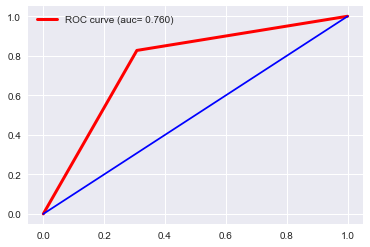

In [308]:
#using to 10 features
X_resampled, y_resampled = os.fit_sample(X[features['feature'][:5].tolist()].values, y)
print(X_resampled.shape)
model= train(X_resampled , y_resampled, rfc, valid_split=0.1, normalize=False)
fpr, tpr, threshold = metrics.roc_curve(y_resampled, model.predict(X_resampled))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='r', lw=3, label='ROC curve (auc= %0.3f)'%roc_auc)
plt.plot([0,1],[0,1], 'b-')
plt.legend(loc='best')
plt.show()